The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 长短期记忆网络（LSTM）
:label:`sec_lstm`

长期以来，隐变量模型存在着长期信息保存和短期输入跳跃的问题。解决这一问题的最早方法之一是长短期存储器(LSTM) :cite:`Hochreiter.Schmidhuber.1997`。它有许多与门控循环单元一样的属性。有趣的是，长短期记忆网络的设计比门控循环单元稍微复杂一些，但比门控循环单元早诞生了近20年。

## 门控记忆单元

可以说，长短期记忆网络的设计灵感来自于计算机的逻辑门。长短期记忆网络引入了*存储单元*（memory cell），或简称为*单元*（cell）。（一些文献认为存储单元是隐藏状态的一种特殊类型）。它们与隐藏状态具有相同的形状，被设计为记录附加信息。为了控制存储单元，我们需要许多门。如，我们需要一个门来从单元中读出条目。我们将其称为*输出门*（output gate）。
另外，需要一个门来决定何时将数据读入单元。我们将其称为*输入门*（input gate）。最后，我们需要一种机制来重置单元的内容，由*遗忘门*（forget gate）来管理。这种设计的动机与门控循环单元相同，即能够通过专用机制决定什么时候记忆或忽略隐藏状态中的输入。让我们看看这在实践中是如何运作的。

### 输入门、忘记门和输出门

就像在门控循环单元中一样，送到长短期记忆网络门的数据是当前时间步的输入和前一个时间步的隐藏状态，如 :numref:`lstm_0` 所示。它们由具有sigmoid激活函数的三个全连接层处理，以计算输入门、遗忘门和输出门的值。因此，这三个门的值都在$(0, 1)$的范围内。

![在长短期记忆模型中计算输入门、遗忘门和输出门。](../img/lstm-0.svg)
:label:`lstm_0`

在数学上，假设有$h$个隐藏单元，批量大小为$n$，输入数为$d$。因此，输入为$\mathbf{X}_t \in \mathbb{R}^{n \times d}$，前一时间步的隐藏状态为$\mathbf{H}_{t-1} \in \mathbb{R}^{n \times h}$。相应地，时间步$t$的门被定义如下：输入门是$\mathbf{I}_t \in \mathbb{R}^{n \times h}$，遗忘门是$\mathbf{F}_t \in \mathbb{R}^{n \times h}$，输出门是$\mathbf{O}_t \in \mathbb{R}^{n \times h}$。它们的计算方法如下：

$$
\begin{aligned}
\mathbf{I}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xi} + \mathbf{H}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{F}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xf} + \mathbf{H}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{O}_t &= \sigma(\mathbf{X}_t \mathbf{W}_{xo} + \mathbf{H}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),
\end{aligned}
$$

其中$\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo} \in \mathbb{R}^{d \times h}$和$\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho} \in \mathbb{R}^{h \times h}$是权重参数，$\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o \in \mathbb{R}^{1 \times h}$是偏置参数。

### 候选记忆单元

接下来，我们设计记忆单元。由于我们还没有指定各种门的操作，所以我们首先介绍候选记忆单元（candidate memory cell）$\tilde{\mathbf{C}}_t \in \mathbb{R}^{n \times h}$。它的计算与上面描述的三个门的计算类似，但是使用$\tanh$函数（值范围为$(-1, 1)$）作为激活函数。这导致在时间步$t$处得出以下方程：

$$\tilde{\mathbf{C}}_t = \text{tanh}(\mathbf{X}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} + \mathbf{b}_c),$$

其中$\mathbf{W}_{xc} \in \mathbb{R}^{d \times h}$和$\mathbf{W}_{hc} \in \mathbb{R}^{h \times h}$是权重参数，$\mathbf{b}_c \in \mathbb{R}^{1 \times h}$是偏置参数。

候选记忆单元的图示如 :numref:`lstm_1` 。

![在长短期记忆模型中计算候选记忆单元。](../img/lstm-1.svg)
:label:`lstm_1`

### 记忆单元

在门控循环单元中，我们有一种机制来控制输入和遗忘（或跳过）。类似地，在长短期记忆网络中，我们有两个门用于这样的目的：输入门$\mathbf{I}_t$控制我们考虑多少来自$\tilde{\mathbf{C}}_t$的新数据，而遗忘门$\mathbf{F}_t$控制我们保留了多少旧记忆单元$\mathbf{C}_{t-1} \in \mathbb{R}^{n \times h}$的内容。使用与前面相同的按元素乘法技巧，我们得出以下更新公式：

$$\mathbf{C}_t = \mathbf{F}_t \odot \mathbf{C}_{t-1} + \mathbf{I}_t \odot \tilde{\mathbf{C}}_t.$$

如果遗忘门始终为1且输入门始终为0，则过去的记忆单元$\mathbf{C}_{t-1}$将随时间被保存并传递到当前时间步。引入这种设计是为了缓解梯度消失问题，并更好地捕获序列中的长距离依赖关系。

这样我们就得到了流程图，如:numref:`lstm_2`。

![在长短期记忆网络模型中计算存储单元。](../img/lstm-2.svg)

:label:`lstm_2`

### 隐藏状态

最后，我们需要定义如何计算隐藏状态$\mathbf{H}_t \in \mathbb{R}^{n \times h}$。这就是输出门发挥作用的地方。在长短期记忆网络中，它仅仅是记忆单元的$\tanh$的门控版本。这确保了$\mathbf{H}_t$的值始终在区间$(-1, 1)$内。

$$\mathbf{H}_t = \mathbf{O}_t \odot \tanh(\mathbf{C}_t).$$

只要输出门接近1，我们就有效地将所有记忆信息传递给预测部分，而对于接近0的输出门，我们只保留存储单元内的所有信息，并且不执行进一步的处理。

:numref:`lstm_3`提供了数据流的图形化演示。

![在长短期记忆模型中计算隐藏状态。](../img/lstm-3.svg)
:label:`lstm_3`

## 从零开始实现

现在，让我们从头开始实现长短期记忆网络。与 :numref:`sec_rnn_scratch` 中的实验相同，我们首先加载时光机器数据集。


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 正在初始化模型参数

接下来，我们需要定义和初始化模型参数。如前所述，超参数`num_hiddens`定义隐藏单元的数量。我们按照标准差0.01的高斯分布初始化权重，并将偏置设置为0。


In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    def three():
        return (normal(
            (num_inputs, num_hiddens)), normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆单元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 定义模型

在初始化函数中，长短期记忆网络的隐藏状态需要返回一个额外的记忆单元，值为0，形状为(批量大小，隐藏单元数)。因此，我们得到以下状态初始化。


In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

实际模型的定义与我们前面讨论的一样：提供三个门和一个额外的记忆单元。请注意，只有隐藏状态会传递到输出层。记忆单元$\mathbf{C}_t$不直接参与输出计算。


In [4]:
def lstm(inputs, state, params):
    [
        W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
        W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

### 训练和预测

让我们通过实例化 :numref:`sec_gru` 中引入的 `RNNModelScratch` 类来训练一个与我们在:numref:`sec_rnn_scratch` 中所实现的相同的LSTM。


perplexity 1.1, 20730.2 tokens/sec on cuda:0
time travelleryou can show black is white by argument said filby


travelleryou can show black is white by argument said filby


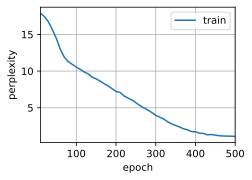

In [5]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

## 简洁实现

使用高级API，我们可以直接实例化`LSTM`模型。这封装了我们上面介绍的所有细节。代码的运行速度要快得多，因为它使用编译后的运算符而不是Python来处理我们在前面详细说明的许多细节。


perplexity 1.0, 302508.7 tokens/sec on cuda:0
time traveller for so it will be convenient to speak of himwas e


travelleryou can show black is white by argument said filby


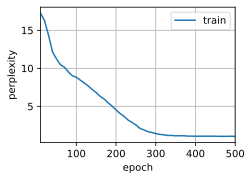

In [6]:
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

长短期记忆网络是典型的具有非平凡状态控制的隐变量自回归模型。多年来已经提出了其许多变体，例如，多层、残差连接、不同类型的正则化。然而，由于序列的长距离依赖性，训练长短期记忆网络和其他序列模型（例如门控循环单元）的成本是相当高的。在后面的内容中，我们将遇到可在某些情况下使用的替代模型，如Transformer。

## 小结

* 长短期记忆网络有三种类型的门：输入门、遗忘门和控制信息流的输出门。
* 长短期记忆网络的隐藏层输出包括“隐藏状态”和“记忆单元”。只有隐藏状态会传递到输出层，记忆单元的信息完全储存在内部。
* 长短期记忆网络可以缓解梯度消失和梯度爆炸。

## 练习

1. 调整超参数，分析它们对运行时间、困惑度和输出顺序的影响。
1. 你需要如何更改模型以生成适当的单词，而不是字符序列？
1. 比较给定隐藏维度的门控循环单元、长短期记忆网络和常规循环神经网络的计算成本。要特别注意训练和推理成本。
1. 既然候选记忆单元通过使用$\tanh$函数来确保值范围在$-1$到$1$之间，那么为什么隐藏状态需要再次使用$\tanh$函数来确保输出值范围在$-1$到$1$之间呢？
1. 为时间序列预测而不是字符序列预测实现LSTM模型。


[Discussions](https://discuss.d2l.ai/t/2768)
